## Desafío entregable #10: Entrenando un algoritmo de Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('Spotify_Track_Dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [4]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## Limpieza de datos

### Tratamiento de datos tipo NaN

In [5]:
df = df.dropna()

### Tratamiento de duplicados

In [6]:
df = df.drop_duplicates(subset = ['track_id'])
df.duplicated(subset = ['track_id']).value_counts()

False    89740
dtype: int64

En entregas pasadas se observó que numerosas canciones estaban duplicadas, poseyendo aquellas los mismos valores en sus variables pero catogorizadas en diferentes géneros.

### Tratamiento de outliers

Existen numerosos outliers en el dataset, el gráfico de cajas inmediatamente abajo ilustra tal situación. Se buscó eliminar sólo aquellos que sean muy distorsivos en las distribuciones, evitando reducir severamente el número de entradas en el dataset.

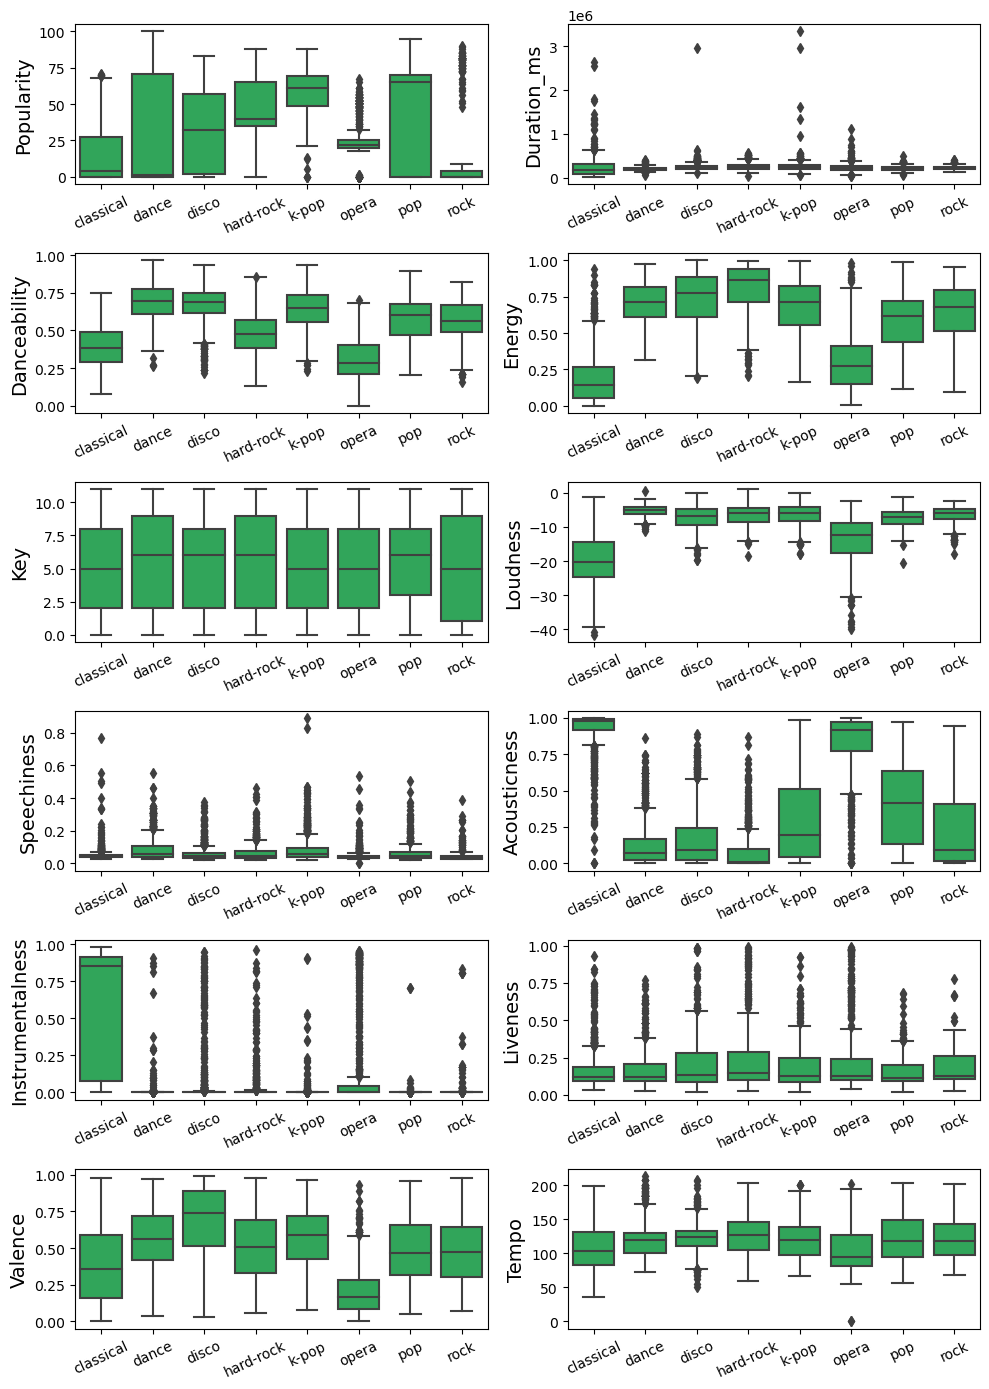

In [7]:
df_sel = df[df['track_genre'].isin(['classical', 'opera', 'rock', 'hard-rock', 'pop', 'k-pop', 'dance', 'disco'])]
columns = df_sel.columns[5:-2] # Selecciono los parámetros que considero más relevantes
l = [i for i in columns if i not in ['explicit', 'mode']]

plt.figure(figsize = (10, 14))
      
for x, column in zip(range(12), df_sel[l]):
    plt.subplot(int(len(l)/2), 2, x+1)
    sns.boxplot(data = df_sel, y = column, x = df_sel['track_genre'], color = '#1DB954') 
    plt.xticks(rotation = 25)
    plt.xlabel("")
    plt.ylabel(l[x].capitalize(), fontsize = 14)
    
plt.tight_layout()

In [8]:
df_filtro = df[((np.abs(stats.zscore(df['duration_ms'])) < 3) & (np.abs(stats.zscore(df['speechiness'])) < 3))]

Sólo fueron removidos los outliers de las variables "duration_ms" y "speechiness", dejando fuera aquellos registros que se aparten en ± 3σ (desviaciones estándar). Esto supone que la distribución es normal, lo que no se cumple para la mayoría de las variables. Abajo se muestran de nuevo los gráficos de caja pero con los outliers eliminados.

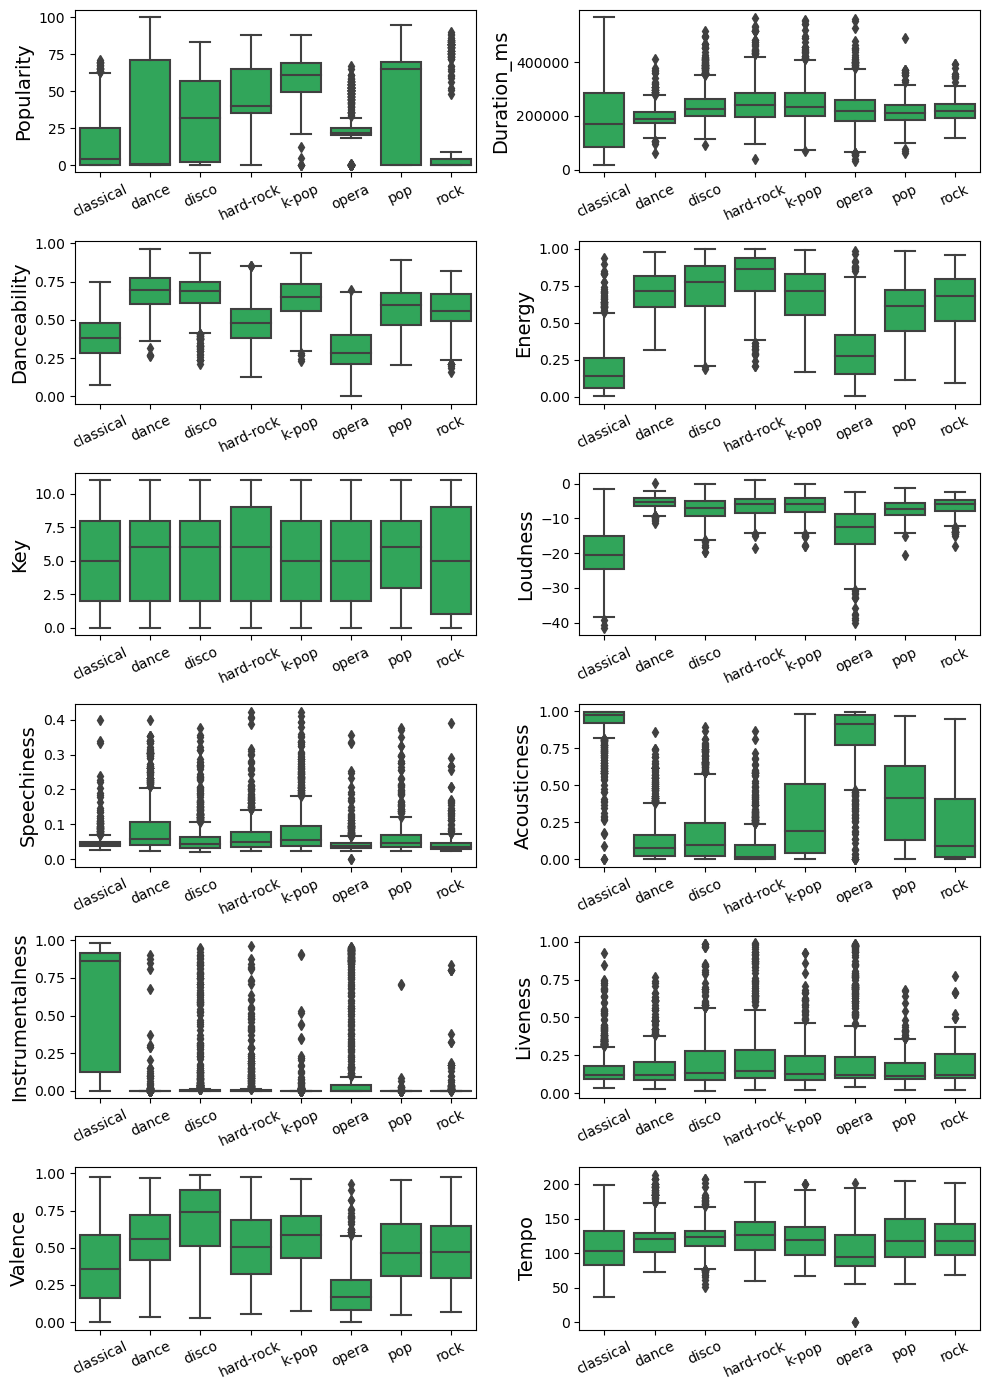

In [9]:
df_sel = df_filtro[df_filtro['track_genre'].isin(['classical', 'opera', 'rock', 'hard-rock', 'pop', 'k-pop', 'dance', 'disco'])]

plt.figure(figsize = (10, 14))
      
for x, column in zip(range(12), df_sel[l]):
    plt.subplot(int(len(l)/2), 2, x+1)
    sns.boxplot(data = df_sel, y = column, x = df_sel['track_genre'], color = '#1DB954') 
    plt.xticks(rotation = 25)
    plt.xlabel("")
    plt.ylabel(l[x].capitalize(), fontsize = 14)
    
plt.tight_layout()

## Curación de datos

In [10]:
df1 = df_filtro.copy()

In [11]:
# Borramos las columnas "Unnamed: 0" y "track_id"
df1.drop(['Unnamed: 0', 'track_id', 'album_name', 'track_name'], axis = 1, inplace = True)

# Pasamos de ms a minutos
df1['duration'] = (df1['duration_ms']/(60 * 1000)).round(2)
df1.drop('duration_ms', axis = 1, inplace = True)

# Expresamos el volumen en números positivos
df1['loudness_db'] = - df1['loudness']
df1.drop('loudness', axis = 1, inplace = True)

# Eliminamos los artistas secundarios
df1[['artists', 'artist_1']] = df['artists'].str.split(';', n = 1, expand = True)
df1.drop('artist_1', axis = 1, inplace = True)

In [12]:
group_names = ['Music', 'Mixed', 'Spoken']
df1['speechiness'] = pd.cut(df1['speechiness'], [0, 0.33, 0.66, 1], labels = group_names, include_lowest = True)

Se eliminaron las columnas "Unnamed: 0", "track_id" que sólo indica el número de fila y que identifica la canción en el servicio Spotify, respectivamente. Además se eliminaron las columnas "album_name" y "track_name". Se expresó la duración de las canciones en minutos (en lugar de milisegundos) y se modificó la columna "loudness" para que informe valores positivos (decibelios). En el caso que una canción posea más de un intérprete, la columna "artists" presenta a los artistas separados por punto y coma (;), por ello se separa las artistas y se selecciona sólo el principal. Por otro lado "speechiness" detecta la presencia de palabra hablada. Mientras más palabra hablada posea (talk show, audiobook, poesía), más cerca de 1 estará el valor. Valores entre 0.33 y 0.66 describen piezas musicales con carácter mixto entre música y palabra hablada. Valores por debajo de 0.33 representan música y otros temas con voz cantada. Con tales rangos crearemos una clasificación cualitativa, con la idea de simplificar el análisis.

In [13]:
df1.head()

,artists,popularity,explicit,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration,loudness_db
0,Gen Hoshino,73,False,0.676,0.4610,1,0,Music,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,3.84,6.746
1,Ben Woodward,55,False,0.420,0.1660,1,1,Music,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,2.49,17.235
2,Ingrid Michaelson,57,False,0.438,0.3590,0,1,Music,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,3.51,9.734
3,Kina Grannis,71,False,0.266,0.0596,0,1,Music,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,3.37,18.515
4,Chord Overstreet,82,False,0.618,0.4430,2,1,Music,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,3.31,9.681


## Preprocesado

### Tratamiento de variables categóricas

In [14]:
df2 = df1.copy()
ord = preprocessing.OrdinalEncoder()

In [15]:
for i in ['artists', 'track_genre', 'explicit', 'speechiness']:
    df2[f'{i}'] = ord.fit_transform(df2[[f'{i}']])
    
df2.head()

,artists,popularity,explicit,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration,loudness_db
0,5583.0,73,0.0,0.676,0.4610,1,0,1.0,0.0322,0.000001,0.3580,0.715,87.917,4,0.0,3.84,6.746
1,1646.0,55,0.0,0.420,0.1660,1,1,1.0,0.9240,0.000006,0.1010,0.267,77.489,4,0.0,2.49,17.235
2,6633.0,57,0.0,0.438,0.3590,0,1,1.0,0.2100,0.000000,0.1170,0.120,76.332,4,0.0,3.51,9.734
3,7993.0,71,0.0,0.266,0.0596,0,1,1.0,0.9050,0.000071,0.1320,0.143,181.740,3,0.0,3.37,18.515
4,2779.0,82,0.0,0.618,0.4430,2,1,1.0,0.4690,0.000000,0.0829,0.167,119.949,4,0.0,3.31,9.681


Amplicamos un encoder a las variables categóricas "artists", "track_genre", "explicit" y "speechiness".

### Escalado de las variables

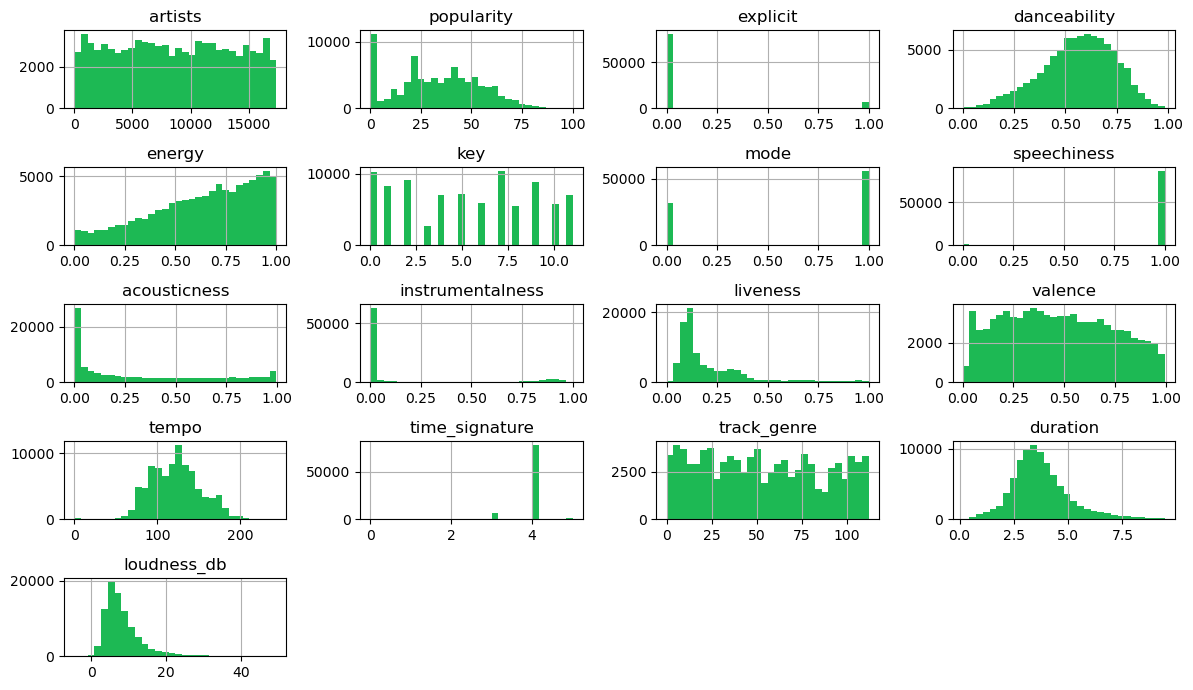

In [16]:
df3 = df2.copy()

df3.iloc[:, :].hist(bins = 30, figsize = (12, 7), color = '#1DB954')
plt.tight_layout()
plt.show()

Puede apreciarse que hay variables que poseen diferentes distribuciones y rangos de valores. Por ejemplo "artists" posee valores entre 0 y 17000 y otras variables corren entre 0 y 1. Esto puede darle un peso desporporcionado a la variable "artists", por ello es que se realiza un escalado a estas variables para que adopten valores entre 0 y 1. 

In [17]:
minmax = preprocessing.MinMaxScaler()

columns = ['artists', 'popularity', 'duration', 'tempo', 'loudness_db']
df3[columns] = minmax.fit_transform(df3[columns])

df3.head()

,artists,popularity,explicit,danceability,energy,key,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,duration,loudness_db
0,0.321750,0.73,0.0,0.676,0.4610,1,0,1.0,0.0322,0.000001,0.3580,0.715,0.361245,4,0.0,0.397422,0.208608
1,0.094859,0.55,0.0,0.420,0.1660,1,1,1.0,0.9240,0.000006,0.1010,0.267,0.318397,4,0.0,0.252417,0.402623
2,0.382261,0.57,0.0,0.438,0.3590,0,1,1.0,0.2100,0.000000,0.1170,0.120,0.313643,4,0.0,0.361976,0.263877
3,0.460639,0.71,0.0,0.266,0.0596,0,1,1.0,0.9050,0.000071,0.1320,0.143,0.746758,3,0.0,0.346939,0.426299
4,0.160154,0.82,0.0,0.618,0.4430,2,1,1.0,0.4690,0.000000,0.0829,0.167,0.492863,4,0.0,0.340494,0.262897


Se puede ver que se tuvo un éxito dispar, las variables "danceability", "tempo", "duration" y "loudness_db" parecen tener una distribución más "normal", mientras que en otras variables no se observan muchos cambios.

## Reducción de la dimensionalidad

Se evaluó cuales son las variables que más peso poseen en el dataset, para ello se utilizar el algoritmo Sequential Feature Selector junto al clasificador K Neighbors.

In [18]:
X = df3.drop(['track_genre'], axis = 1) 
y = df3['track_genre']

print(X.columns.size)

16


In [19]:
X2 = X.iloc[::10,:] 
y2 = y.iloc[::10]

Dado que el dataset posee numerosos, lo que hace que el proceso de reducción de dimensionalidad sea muy lento se decidió utilizar sólo uno cada 10 registros. De esta manera los tiempos se reducen notablemente.

Se utilizó el algoritmo KNeighborsClassifier, con k = 5 para realizar el proceso de Feature Selection, tomando como métrica la precisión. Se seleccionó 3, 5, 7, 9, 11, 13 y 15 variables en cada caso, la cual se denominan Sprint 3, Sprint 5, ..., y Sprint 15. Se aplicó sólo la dirección "forward", dado que en entregas pasadas fue la que dió mejores resultados 

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
knn = KNeighborsClassifier(n_neighbors = 5)

forw = {}

for i in [3, 5, 7, 9, 11, 13, 15]:
    forw[f'sfs_{i}'] = SequentialFeatureSelector(knn, n_features_to_select = i)
    forw[f'sfs_{i}'].fit(X2, y2)
    print(f'Las {i} variables seleccionadas son: \n', list(X2.columns[forw[f'sfs_{i}'].get_support()]))
    forw[f'sfs_{i}_var'] = X2.columns[forw[f'sfs_{i}'].get_support()]

Las 3 variables seleccionadas son: 
 ['artists', 'explicit', 'speechiness']
Las 5 variables seleccionadas son: 
 ['artists', 'explicit', 'mode', 'speechiness', 'time_signature']
Las 7 variables seleccionadas son: 
 ['artists', 'popularity', 'explicit', 'mode', 'speechiness', 'instrumentalness', 'time_signature']
Las 9 variables seleccionadas son: 
 ['artists', 'popularity', 'explicit', 'mode', 'speechiness', 'instrumentalness', 'time_signature', 'duration', 'loudness_db']
Las 11 variables seleccionadas son: 
 ['artists', 'popularity', 'explicit', 'danceability', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'time_signature', 'duration', 'loudness_db']
Las 13 variables seleccionadas son: 
 ['artists', 'popularity', 'explicit', 'danceability', 'energy', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'time_signature', 'duration', 'loudness_db']
Las 15 variables seleccionadas son: 
 ['artists', 'popularity', 'explicit', 'danceability', 'energy', 'mode', 

### KN con Forward Feature Selector

A continuación, se utilizaron modelos de KNeighborsClassifier usando las variables seleccionada en cada caso y se evaluarán las métricas.

In [22]:
knn = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)

accuracy_forw, recall_forw, f1_forw = [], [], []

for i in [3, 5, 7, 9, 11, 13, 15]:
    X_i = X[list(X2.columns[forw[f'sfs_{i}'].get_support()])]
    
    X_train, X_test, y_train, y_test = train_test_split(X_i, y, random_state = 42)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    accuracy_forw.append(accuracy_score(y_test, y_pred))
    recall_forw.append(recall_score(y_test, y_pred, average = 'macro'))
    f1_forw.append(f1_score(y_test, y_pred, average = 'macro'))

In [23]:
Model = [f'Sprint {2*i+1}' for i in range(1,8)]
comparacion_forw = pd.DataFrame({'Modelo': Model, 'Accuracy': accuracy_forw, 'Recall': recall_forw, 'F1': f1_forw})
comparacion_forw.round(2)

,Modelo,Accuracy,Recall,F1
0,Sprint 3,0.70,0.67,0.68
1,Sprint 5,0.57,0.55,0.55
2,Sprint 7,0.27,0.26,0.27
3,Sprint 9,0.26,0.25,0.25
4,Sprint 11,0.28,0.27,0.27
5,Sprint 13,0.28,0.26,0.27
6,Sprint 15,0.27,0.26,0.26


Resulta llamativo que las métricas disminuyen rápidamente hasta el Sprint 7, manteniéndose los valores para posteriores sprints. Seleccionamos el sprint 3 para evalua el efecto del número de vecinos.

In [24]:
accuracy_knn, recall_knn, f1_knn = [], [], []

for i in [3, 5, 7, 9, 10]:
    knn = KNeighborsClassifier(n_neighbors = i, n_jobs = -1)
    
    X_3 = X[list(X2.columns[forw[f'sfs_{3}'].get_support()])]
    
    X_train, X_test, y_train, y_test = train_test_split(X_3, y, random_state = 42)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    accuracy_knn.append(accuracy_score(y_test, y_pred))
    recall_knn.append(recall_score(y_test, y_pred, average = 'macro'))
    f1_knn.append(f1_score(y_test, y_pred, average = 'macro'))

In [25]:
neighbors = [f'Neighbors {i}' for i in [3, 5, 7, 9, 10]]
knn_neighbors = pd.DataFrame({'Modelo': neighbors, 'Accuracy': accuracy_knn, 'Recall': recall_knn, 'F1': f1_knn})
knn_neighbors.round(2)

,Modelo,Accuracy,Recall,F1
0,Neighbors 3,0.74,0.71,0.72
1,Neighbors 5,0.70,0.67,0.68
2,Neighbors 7,0.67,0.64,0.64
3,Neighbors 9,0.64,0.61,0.61
4,Neighbors 10,0.62,0.60,0.59


El mejor resultado se obtiene con k = 3.

## Selección de modelos

A continuación se probarán distintos modelos de clasificación y se evaluarán las métricas obtenidas. Los algoritmos empleados son KNeighbors, Gaussian Naive Bayes, Decision tree, Randon Forest, XGBoost y Ada Boost.

Se utilizó la lista de tres variables ("artists", "explicit" y "speechiness") seleccionadas por el Forward Feature Selector utilizando KNN para todos los modelos.

In [26]:
X_3 = X[list(X2.columns[forw[f'sfs_{3}'].get_support()])]
X_train, X_test, y_train, y_test = train_test_split(X_3, y, random_state = 42)

### KNN

In [27]:
knn = KNeighborsClassifier(n_neighbors = i, n_jobs = -1)

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred, average = 'macro')
f1_knn = f1_score(y_test, y_pred, average = 'macro')

print(f'Accuracy = {round(accuracy_knn, 2)} \nRecall = {round(recall_knn, 2)} \nF1 = {round(f1_knn, 2)}')

Accuracy = 0.62 
Recall = 0.6 
F1 = 0.59


### Gaussian Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB

In [29]:
nb = GaussianNB()

nb.fit(X_train, y_train)
y_test_pred = nb.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_test_pred)
recall_nb = recall_score(y_test, y_test_pred, average = 'macro')
f1_nb = f1_score(y_test, y_test_pred, average = 'macro')

print(f'Accuracy = {round(accuracy_nb, 2)} \nRecall = {round(recall_nb, 2)} \nF1 = {round(f1_nb, 2)}')

Accuracy = 0.02 
Recall = 0.01 
F1 = 0.0


### Decision Tree 

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
dtc = DecisionTreeClassifier(min_samples_split = 10)

dtc.fit(X_train, y_train)
y_test_pred = dtc.predict(X_test)

accuracy_dtc = accuracy_score(y_test, y_test_pred)
recall_dtc = recall_score(y_test, y_test_pred, average = 'macro')
f1_dtc = f1_score(y_test, y_test_pred, average = 'macro')

print(f'Accuracy = {round(accuracy_dtc, 2)} \nRecall = {round(recall_dtc, 2)} \nF1 = {round(f1_dtc, 2)}')

Accuracy = 0.71 
Recall = 0.68 
F1 = 0.69


### Random Forest 

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
rfc = RandomForestClassifier(max_depth = 10, n_estimators = 100)

rfc.fit(X_train, y_train)
y_test_pred = rfc.predict(X_test)

accuracy_rfc = accuracy_score(y_test, y_test_pred)
recall_rfc = recall_score(y_test, y_test_pred, average = 'macro')
f1_rfc = f1_score(y_test, y_test_pred, average = 'macro')

print(f'Accuracy = {round(accuracy_rfc, 2)} \nRecall = {round(recall_rfc, 2)} \nF1 = {round(f1_rfc, 2)}')

Accuracy = 0.13 
Recall = 0.12 
F1 = 0.14


### XGBoost

In [34]:
from xgboost import XGBClassifier

In [35]:
xgb = XGBClassifier(max_depth = 5, n_estimators = 40)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred, average = 'macro')
f1_xgb = f1_score(y_test, y_pred, average = 'macro')

print(f'Accuracy = {round(accuracy_xgb, 2)} \nRecall = {round(recall_xgb, 2)} \nF1 = {round(f1_xgb, 2)}')

Accuracy = 0.57 
Recall = 0.55 
F1 = 0.56


### Ada Boost

In [36]:
from sklearn.ensemble import AdaBoostClassifier

In [37]:
abc = AdaBoostClassifier()

abc.fit(X_train, y_train)
y_test_pred = abc.predict(X_test)

accuracy_abc = accuracy_score(y_test, y_test_pred)
recall_abc = recall_score(y_test, y_test_pred, average = 'macro')
f1_abc = f1_score(y_test, y_test_pred, average = 'macro')

print(f'Accuracy = {round(accuracy_abc, 2)} \nRecall = {round(recall_abc, 2)} \nF1 = {round(f1_abc, 2)}')

Accuracy = 0.05 
Recall = 0.04 
F1 = 0.02


### Comparación de modelos

In [38]:
comparacion = pd.DataFrame({'Modelo': ['KNN', 'Gaussian NB', ' Decision Tree', 'Random Forest', 'XGBoost', 'Ada Boost'], 'Accuracy': [accuracy_knn, accuracy_nb, accuracy_dtc, accuracy_rfc, accuracy_xgb, accuracy_abc], 'Recall': [recall_knn, recall_nb, recall_dtc, recall_rfc, recall_xgb, recall_abc], 'F1': [f1_knn, f1_nb, accuracy_dtc, f1_rfc, f1_xgb, f1_abc]})

comparacion.round(2)

,Modelo,Accuracy,Recall,F1
0,KNN,0.62,0.60,0.59
1,Gaussian NB,0.02,0.01,0.00
2,Decision Tree,0.71,0.68,0.71
3,Random Forest,0.13,0.12,0.14
4,XGBoost,0.57,0.55,0.56
5,Ada Boost,0.05,0.04,0.02


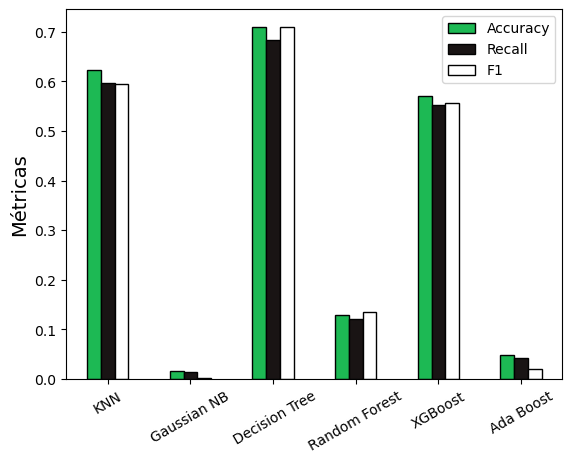

In [39]:
comparacion.plot(x = 'Modelo', kind = 'bar', color = ['#1DB954', '#191414', '#ffffff'], edgecolor='black')

plt.xticks(rotation = 30)
plt.xlabel('')
plt.ylabel('Métricas', fontsize = 14)
plt.legend(loc = 'best')
plt.show()

Se observa un gran variación en las métricas obtenidas en cada modelo. Recordemos que no se hizo ajuste fino de los hiperparámetros en ninguno de ellos, por lo que existe amplio margen de mejora. Sin embargo, si comparamos las métricas obtenidas empleando KNN en entregas pasadas, en el cual las métricas apenas superaban el 20 %, con lo valores ahora obtenidos observamos una mejora sustancial en los resultados.